# Assignment:-

# Naive Bayes on Amazon Fine Food Reviews Analysis

## Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


## 1. Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2). Use BoW, TF-IDF, Avg-Word2Vec,TF-IDF-Word2Vec to vectorise the reviews. 
Apply Naive Bayes Algorithm for Amazon fine food  reviews
find right alpha(α) using cross validation
Get feature importance for positive class and Negative class
Evaluate the test data on various performance metrics like accuracy, f1-score, precision, recall,etc.



##  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import f1_score


## 1.1 Connecting SQL file

In [2]:
#Loading the data
con = sqlite3.connect('./final.sqlite')

data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)

In [3]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


## 1.2 Data Preprocessing

In [4]:
data.Score.value_counts()
#i had done data preprocessing i had stored in final.sqlite now loaded this file no need to do again data preprocessing


positive    307061
negative     57110
Name: Score, dtype: int64

## 1.3 Sorting the data

In [5]:
# sorting the data according to the time-stamp
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.4 Mapping

In [6]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative
sorted_data.head()


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.5 Taking First 150k Rows

In [7]:
# We will collect different 150000 rows without repetition from time_sorted_data dataframe
my_final = sorted_data[:150000]
print(my_final.shape)
my_final.head()


(150000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.6 Spliting data into train and test based on time (70:30)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


x=my_final['CleanedText'].values
y=my_final['Score']

#Splitting data into train test and cross validation 
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size =0.3,random_state = 42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(105000,)
(45000,)
(105000,)
(45000,)


## 2.  Techniques For Vectorization

## Why we have to convert text to vector
By converting text to vector we can use whole power of linear algebra.we can find a plane to seperate

## 2.1 BOW


In [9]:
#Bow

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() 
final_counts_Bow_tr= count_vect.fit_transform(x_train)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_tr))
print("the shape of out text BOW vectorizer ",final_counts_Bow_tr.get_shape())
print("the number of unique words ", final_counts_Bow_tr.get_shape()[1])
final_counts_Bow_test= count_vect.transform(x_test)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_test))
print("the shape of out text BOW vectorizer ",final_counts_Bow_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (105000, 38300)
the number of unique words  38300
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (45000, 38300)


## 2.1.1 Standardizing Data

In [10]:
# Data-preprocessing: Standardizing the data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_Bow_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_Bow_test)
print(standardized_data_test.shape)


(105000, 38300)
(45000, 38300)


## 2.2 Applying Multinomial Naive bayes algorithm


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.model_selection import cross_val_score

mylist=[10**-5,10**-4,10**-3,10**-2,10**-1,10**0,0.5,1,5,10,50,100,500,1000,5000,10000]
    
# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for alpha in mylist:
    mnb = MultinomialNB(alpha = alpha)
    scores = cross_val_score(mnb,standardized_data_train, y_train, cv = 2, scoring = 'f1',n_jobs=-1)
    cv_scores.append(scores.mean())

optimal_alpha = mylist[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.010.


## 2.3 Plotting a graph  Accuracy vs alpha 


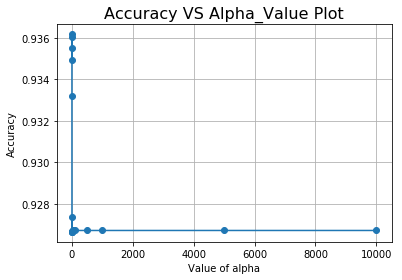



Alpha values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]

Accuracy for each alpha value is :
  [0.93493 0.93553 0.93604 0.93618 0.93322 0.92665 0.92738 0.92665 0.92665
 0.9267  0.92672 0.92672 0.92672 0.92672 0.92672 0.92672]


In [13]:
# plot accuracy vs alpha 
plt.plot(mylist, cv_scores,marker='o')
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha_Value Plot',size=16)
plt.grid()
plt.show()

print("\n\nAlpha values :\n",mylist)
print("\nAccuracy for each alpha value is :\n ", np.round(cv_scores,5))

In [14]:
# To choose optimal_alpha using cross validation

# instantiate learning model alpha = optimal_alpha
nb_optimal =  MultinomialNB(alpha = optimal_alpha)

# fitting the model
nb_optimal.fit(standardized_data_train, y_train)

# predict the response
pred_bow = nb_optimal.predict(standardized_data_test)
pred_bow1 = nb_optimal.predict(standardized_data_train)

# evaluate f1score of test data
f1score_bow = f1_score(y_test, pred_bow) * 100
print('\nThe f1score of the Naivebayes in test for alpha = {}'.format((optimal_alpha, f1score_bow)))

# evaluate f1score of train data
f1score1_bow = f1_score(y_train, pred_bow1) * 100
print('\nThe f1score of the Naivebayes in test for alpha = {}'.format((optimal_alpha, f1score1_bow)))


The f1score of the Naivebayes in test for alpha = (0.01, 93.69275754573356)

The f1score of the Naivebayes in test for alpha = (0.01, 94.33897350889814)


## 2.5 Error on Test data

In [15]:
# Error on test data
test_error_bow = 100-f1score_bow
print("Test Error %f%%" % (test_error_bow))

Test Error 6.307242%


## 2.6 Confusion matrix

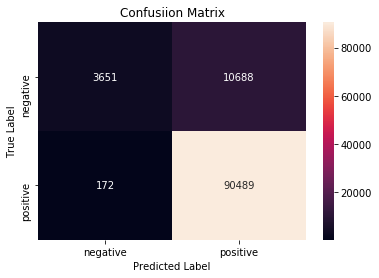

 true negitves are 3651 
 false positives are 10688 
 false negatives are 172
 true positives are 90489 
 


In [16]:
#Confusion matrix of train data 
from sklearn.metrics import confusion_matrix
cm_bow = confusion_matrix(y_train,pred_bow1)
cm_bow

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

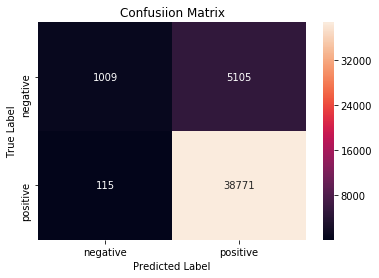

 true negitves are 1009 
 false positives are 5105 
 false negatives are 115
 true positives are 38771 
 


In [17]:
#Confusion matrix of train data 
cm_bow = confusion_matrix(y_test,pred_bow)
cm_bow
# plot confusion matrix to describe the performance of classifier.

import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

## 2.7 Classification Report

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_bow))

              precision    recall  f1-score   support

           0       0.90      0.17      0.28      6114
           1       0.88      1.00      0.94     38886

   micro avg       0.88      0.88      0.88     45000
   macro avg       0.89      0.58      0.61     45000
weighted avg       0.89      0.88      0.85     45000



## 2.8 Precision Score

In [19]:
# Micro-average is preferable if there is a class imbalance problem.
#In Micro-average method, you sum up the individual true positives, false positives, and false negatives of the system for different sets 
from sklearn.metrics import precision_score
precision_score = precision_score(y_test,pred_bow,average='micro')
print("precision_score for the BoW MultinomialNB model is = %f" % (precision_score))

precision_score for the BoW MultinomialNB model is = 0.884000


## 2.9 Recall Score

In [20]:
from sklearn.metrics import recall_score
recall_score = recall_score(y_test,pred_bow,average='micro')
print("recall_score for the BoW MultinomialNB model is = %f" % (recall_score))

recall_score for the BoW MultinomialNB model is = 0.884000


## 2.10 Feature Importance

In [21]:
# To get all the features name 
bow_features = count_vect.get_feature_names()


In [22]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 38300)

## 2.11 Log Probabilites

In [23]:
# Number of samples encountered for each class during fitting
nb_optimal.class_count_

# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob


array([[-13.3050394 , -15.7770738 , -15.7770738 , ..., -15.7770738 ,
        -15.7770738 , -15.7770738 ],
       [-15.39169358, -14.69096711, -14.82286307, ..., -16.52229534,
        -15.1487754 , -14.70465682]])

In [24]:
#You can get the importance of each word out of the fit model by using the coefs_ or feature_log_prob_

feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(38300, 2)

In [25]:
# To show top 10 feature from both class
# Feature Importance
print("\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])
print("\n Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])


 Top 10 Positive Features:-
 tast      -4.409965
great     -4.426272
like      -4.427358
love      -4.439141
good      -4.473908
flavor    -4.603431
product   -4.710896
use       -4.725006
tea       -4.796099
one       -4.803616
Name: 1, dtype: float64

 Top 10 Negative Features:-
 tast      -4.079251
like      -4.233607
product   -4.368777
flavor    -4.700390
one       -4.725823
would     -4.857008
tri       -4.860776
good      -4.913829
buy       -5.006692
coffe     -5.052480
Name: 0, dtype: float64


## 3. TF-IDF

In [26]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()


In [27]:
final_counts_tfidf_tr= tf_idf_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(final_counts_tfidf_tr))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_tr.get_shape())
print("the number of unique words ", final_counts_tfidf_tr.get_shape()[1])
final_counts_tfidf_test= tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_tfidf_test))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_test.get_shape())
print("the number of unique words ", final_counts_tfidf_test.get_shape()[1])



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (105000, 38300)
the number of unique words  38300
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (45000, 38300)
the number of unique words  38300


## 3.1 Standardizing Data

In [28]:
# Data-preprocessing: Standardizing the data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_tfidf_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_tfidf_test)
print(standardized_data_test.shape)


(105000, 38300)
(45000, 38300)


## 3.2 Applying Multinomial Naive bayes algorithm


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.model_selection import cross_val_score

mylist=[10**-5,10**-4,10**-3,10**-2,10**-1,10**0,0.5,1,5,10,50,100,500,1000,5000,10000]
    
# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for alpha in mylist:
    mnb = MultinomialNB(alpha = alpha)
    scores = cross_val_score(mnb,standardized_data_train, y_train, cv = 2, scoring = 'f1',n_jobs=-1)
    cv_scores.append(scores.mean())

# changing to misclassification error

# determining best alpha
optimal_a_binary_tfidf = mylist[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is {}'.format(optimal_a_binary_tfidf))




The optimal value of alpha is 0.01


## 3.3 Plotting a graph between Accuracy vs alpha

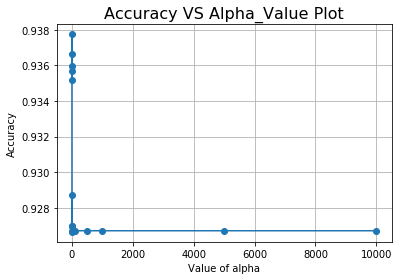



Alpha values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]

Accuracy for each alpha value is :
  [0.93518 0.93569 0.93663 0.93775 0.93598 0.92696 0.9287  0.92696 0.92665
 0.9267  0.92672 0.92672 0.92672 0.92672 0.92672 0.92672]


In [31]:
# plot accuracy vs alpha 
plt.plot(mylist, cv_scores,marker='o')
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha_Value Plot',size=16)
plt.grid()
plt.show()

print("\n\nAlpha values :\n",mylist)
print("\nAccuracy for each alpha value is :\n ", np.round(cv_scores,5))

In [32]:
# To choose optimal_alpha using cross validation

# instantiate learning model alpha = optimal_alpha
nb_optimal =  MultinomialNB(alpha = optimal_a_binary_tfidf)

# fitting the model
nb_optimal.fit(standardized_data_train, y_train)

# predict the response
pred_tfidf = nb_optimal.predict(standardized_data_test)
pred_tfidf1 = nb_optimal.predict(standardized_data_train)

from sklearn.metrics import f1_score

# evaluate f1score of test data
f1score_tfidf = f1_score(y_test, pred_tfidf) * 100
print('\nThe f1score of the Naivebayes in test for alpha = {}'.format((optimal_a_binary_tfidf, f1score_tfidf)))

# evaluate f1score of train data
f1score1_tfidf = f1_score(y_train, pred_tfidf1) * 100
print('\nThe f1score of the Naivebayes in test for alpha = {}'.format((optimal_a_binary_tfidf, f1score1_tfidf)))





The f1score of the Naivebayes in test for alpha = (0.01, 93.851463011568)

The f1score of the Naivebayes in test for alpha = (0.01, 95.1529377091973)


## 3.5 Error on Test data

In [33]:
# Error on test data
test_error_tfidf = 100-f1score_tfidf
print("Test Error %f%%" % (test_error_tfidf))

Test Error 6.148537%


## 3.6 Confusion matrix

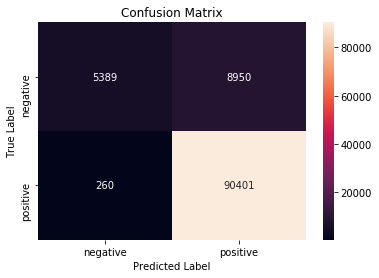

 true negitves are 5389 
 false positives are 8950 
 false negatives are 260
 true positives are 90401 
 


In [34]:
# Confusion Matrix of train data
from sklearn.metrics import confusion_matrix
cm_tfidf = confusion_matrix(y_train, pred_tfidf1)
cm_tfidf

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm_tfidf = pd.DataFrame(cm_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm_tfidf, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))


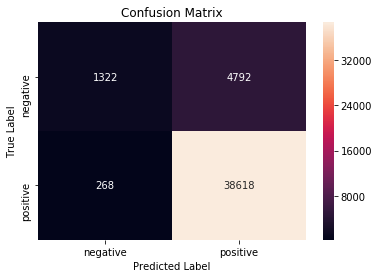

 true negitves are 1322 
 false positives are 4792 
 false negatives are 268
 true positives are 38618 
 


In [35]:
# Confusion Matrix of train data
from sklearn.metrics import confusion_matrix
cm_tfidf = confusion_matrix(y_test, pred_tfidf)
cm_tfidf

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm_tfidf = pd.DataFrame(cm_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm_tfidf, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))


## 3.7 Classification report

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_tfidf))


              precision    recall  f1-score   support

           0       0.83      0.22      0.34      6114
           1       0.89      0.99      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.86      0.60      0.64     45000
weighted avg       0.88      0.89      0.86     45000



## 3.8 Precision Score

In [37]:
# Micro-average is preferable if there is a class imbalance problem.
from sklearn.metrics import precision_score
precision_score = precision_score(y_test,pred_tfidf,average='micro')
print("Precision_score for the tfidf MultinomialNB model is = %f" % (precision_score))

Precision_score for the tfidf MultinomialNB model is = 0.887556


## 3.9 Recall Score

In [38]:
from sklearn.metrics import recall_score
recall_score = recall_score(y_test,pred_tfidf,average='micro')
print("Recall_score for the tfidf MultinomialNB model is = %f" % (recall_score))

Recall_score for the tfidf MultinomialNB model is = 0.887556


## 3.10 Feature Importance

In [39]:
# To get all the features name 
tfidf_features = tf_idf_vect.get_feature_names()


In [40]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 38300)

## 3.11 Log probabilites

In [41]:
# Number of samples encountered for each class during fitting
nb_optimal.class_count_

# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob


array([[-12.57961546, -15.74121872, -15.74121872, ..., -15.74121872,
        -15.74121872, -15.74121872],
       [-14.76807887, -13.83826433, -13.965373  , ..., -15.68888286,
        -14.34333729, -14.04586222]])

In [42]:
#You can get the importance of each word out of the fit model by using the coefs_ or feature_log_prob_

feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(38300, 2)

In [43]:
# To show top 10 feature from both class
# Feature Importance
print("\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])
print("\n Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])


 Top 10 Positive Features:-
 great     -5.048001
tea       -5.074210
love      -5.078242
tast      -5.129591
good      -5.132252
like      -5.154971
flavor    -5.209995
coffe     -5.241921
product   -5.300613
use       -5.331915
Name: 1, dtype: float64

 Top 10 Negative Features:-
 tast      -4.826272
like      -4.986401
product   -5.016585
would     -5.338266
flavor    -5.340181
coffe     -5.371336
one       -5.376947
tri       -5.477280
order     -5.494306
buy       -5.495992
Name: 0, dtype: float64


## 4. Model performance table

In [44]:
# model performance table
models = pd.DataFrame({'Model': ['Naive Bayes with Bow', "Naive Bayes with TFIDF"], 'Hyper Parameter(alpha)': [optimal_alpha, optimal_a_binary_tfidf], 'Test Error': [test_error_bow,test_error_tfidf], 'Accuracy': [f1score_bow, f1score_tfidf]}, columns = ["Model", "Hyper Parameter(alpha)", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy')

,Model,Hyper Parameter(alpha),Test Error,Accuracy
0,Naive Bayes with Bow,0.01,6.307242,93.692758
1,Naive Bayes with TFIDF,0.01,6.148537,93.851463


# 5. Conclusion